# Notebook for Training Model on Google Colab

Cloning repository and unzip data:

In [ ]:
!git clone https://github.com/ianmm2d/Microstructure-Predictions.git
import os

# Change working directory from /content to your repo folder
os.chdir('/content/Microstructure-Predictions')

# Now unzip your data
!unzip -q data/npy_images/microstructures_zip.zip -d data/npy_images/

fatal: destination path 'Microstructure-Predictions' already exists and is not an empty directory.
replace data/npy_images/microstructure_00003.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

Importing modules and libraries:

In [1]:
%cd /content/Microstructure-Predictions

/content/Microstructure-Predictions


In [2]:
from src.pipeline import DataPipeline
from src.model import CNN
from src.train import train_and_evaluate, plot_loss_curves
from importlib import reload

import numpy as np
import torch
import matplotlib.pyplot as plt

# Reload modules (use the module names directly, not the class/function names)
# reload(src.pipeline)
# reload(src.model)
# reload(src.train)

import numpy as np
import torch
import matplotlib.pyplot as plt
print("Imports successful!")

Imports successful!


## Run data pipeline:

In [3]:
#Data loading and preprocessing
image_dir = 'data/npy_images'
label_path = 'data/properties/material_property.csv'
batch_size = 16
test_split = 0.1
val_split = 0.1
pipeline = DataPipeline(image_dir, label_path,batch_size, test_split, val_split)
dataloaders = pipeline.load()
train_loader = dataloaders['train']
val_loader = dataloaders['val']

## Training configure:

In [4]:
# Initialize the model, loss function, and optimizer
sample_input, _ = next(iter(train_loader))
_, c, h, w = sample_input.shape
model = CNN(input_channels=c, input_height=h, input_width=w)
loss = torch.nn.MSELoss()
lr = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr, weight_decay=1e-5)
epochs = 100
seed = 30

## Training:

Epoch 1/100, Train Loss: 1.0041, Val Loss: 1.0353
Epoch 2/100, Train Loss: 0.9640, Val Loss: 0.7636
Epoch 3/100, Train Loss: 0.1674, Val Loss: 0.0624
Epoch 4/100, Train Loss: 0.0716, Val Loss: 0.0607
Epoch 5/100, Train Loss: 0.0670, Val Loss: 0.0595
Epoch 6/100, Train Loss: 0.0648, Val Loss: 0.0585
Epoch 7/100, Train Loss: 0.0649, Val Loss: 0.0606
Epoch 8/100, Train Loss: 0.0644, Val Loss: 0.0581
Epoch 9/100, Train Loss: 0.0597, Val Loss: 0.0556
Epoch 10/100, Train Loss: 0.0604, Val Loss: 0.0526
Epoch 11/100, Train Loss: 0.0576, Val Loss: 0.0910
Epoch 12/100, Train Loss: 0.0595, Val Loss: 0.0527
Epoch 13/100, Train Loss: 0.0548, Val Loss: 0.0676
Epoch 14/100, Train Loss: 0.0576, Val Loss: 0.0576
Epoch 15/100, Train Loss: 0.0547, Val Loss: 0.0521
Epoch 16/100, Train Loss: 0.0541, Val Loss: 0.0502
Epoch 17/100, Train Loss: 0.0528, Val Loss: 0.0486
Epoch 18/100, Train Loss: 0.0528, Val Loss: 0.0531
Epoch 19/100, Train Loss: 0.0502, Val Loss: 0.0474
Epoch 20/100, Train Loss: 0.0517, Val Lo

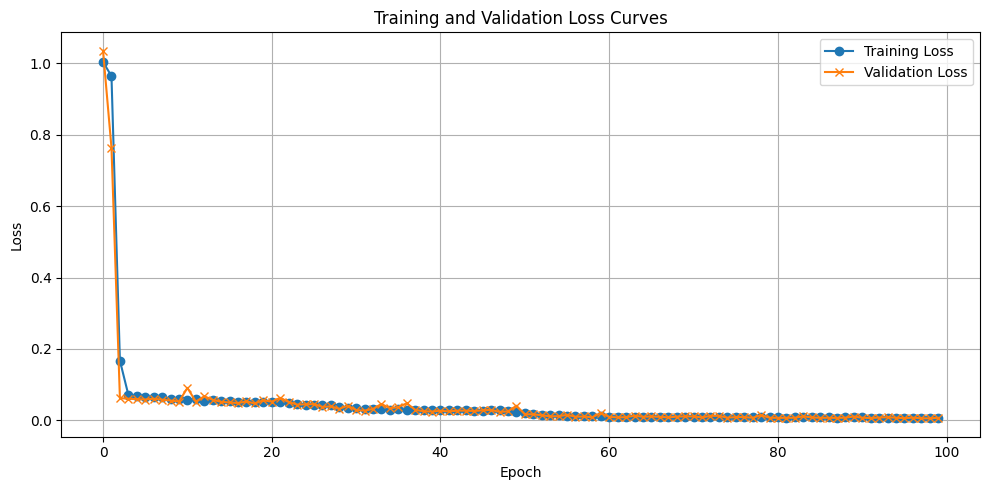

In [5]:
# Train the model
train_losses, val_losses = train_and_evaluate(model, train_loader, val_loader, loss, optimizer, epochs, seed=30)
# Plot training and validation loss curves
plot_loss_curves(train_losses, val_losses)

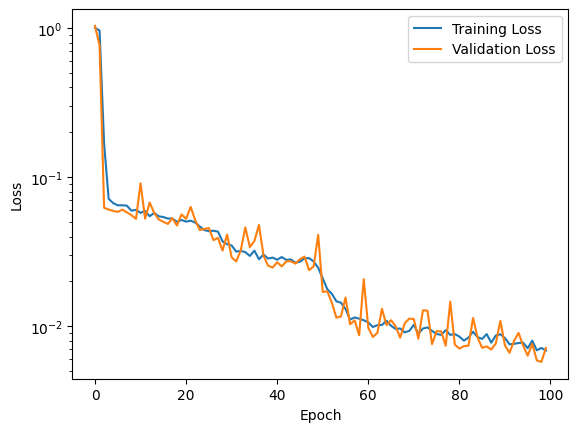

In [6]:
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.yscale('log')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Evaluating model for train dataset:

In [31]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_X).squeeze()
        all_predictions.append(outputs.cpu())
        all_targets.append(batch_y.cpu())

    # Print first 10 predictions and targets
    sample_preds = torch.cat(all_predictions)[:10]
    sample_targets = torch.cat(all_targets)[:10]
    print("Sample predictions:\n", sample_preds)
    print("Corresponding targets:\n", sample_targets)

# Concatenate everything on CPU after inference
predictions = torch.cat(all_predictions).numpy()
y_true = torch.cat(all_targets).numpy()

# Reshape predictions to (N, 1) if they somehow became (N,)
if predictions.ndim == 1:
    predictions = predictions.reshape(-1, 1)
# Reshape y_true to (N, 1) if it's (N,)
if y_true.ndim == 1:
    y_true = y_true.reshape(-1, 1)

# Apply inverse normalization
predictions = predictions * pipeline.y_std.item() + pipeline.y_mean.item()
y_true = y_true * pipeline.y_std.item() + pipeline.y_mean.item()

# Compute relative error and accuracy
relative_errors = np.abs(predictions - y_true) / y_true
within_30_percent = relative_errors < 0.30
accuracy_30 = np.mean(within_30_percent)
evaluation_metric = np.mean(relative_errors)

print(f"Evaluation Metric: {evaluation_metric:.2%}")
print(f"Fraction within 30% error: {accuracy_30:.2%}")

Sample predictions:
 tensor([-1.2647, -1.4542,  0.7207, -0.9723,  0.8615, -1.2216, -1.1622, -1.1387,
         1.4752, -0.7420])
Corresponding targets:
 tensor([[-1.2133],
        [-1.4099],
        [ 0.6836],
        [-0.9532],
        [ 0.8031],
        [-1.1914],
        [-1.1659],
        [-1.1742],
        [ 1.7558],
        [-0.7710]])
Evaluation Metric: 2.18%
Fraction within 30% error: 100.00%


## Evaluating model for val dataset:

In [30]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(device)
        batch_y = batch_y.to(device)

        outputs = model(batch_X).squeeze()
        all_predictions.append(outputs.cpu())
        all_targets.append(batch_y.cpu())

    # Print first 10 predictions and targets
    sample_preds = torch.cat(all_predictions)[:10]
    sample_targets = torch.cat(all_targets)[:10]
    print("Sample predictions:\n", sample_preds)
    print("Corresponding targets:\n", sample_targets)

# Concatenate everything on CPU after inference
predictions = torch.cat(all_predictions).numpy()
y_true = torch.cat(all_targets).numpy()

# Reshape predictions to (N, 1) if they somehow became (N,)
if predictions.ndim == 1:
    predictions = predictions.reshape(-1, 1)
# Reshape y_true to (N, 1) if it's (N,)
if y_true.ndim == 1:
    y_true = y_true.reshape(-1, 1)

# Apply inverse normalization
predictions = predictions * pipeline.y_std.item() + pipeline.y_mean.item()
y_true = y_true * pipeline.y_std.item() + pipeline.y_mean.item()

# Compute relative error and accuracy
relative_errors = np.abs(predictions - y_true) / y_true
within_30_percent = relative_errors < 0.30
accuracy_30 = np.mean(within_30_percent)
evaluation_val_metric = np.mean(relative_errors)

print(f"Evaluation Metric: {evaluation_val_metric:.2%}")
print(f"Fraction within 30% error: {accuracy_30:.2%}")


Sample predictions:
 tensor([-0.7382,  0.6011,  1.5022,  1.4897, -0.2520, -0.7583, -0.6606, -1.3140,
        -1.2449, -1.4341])
Corresponding targets:
 tensor([[-0.7451],
        [ 0.5730],
        [ 1.4814],
        [ 1.4007],
        [-0.1853],
        [-0.8240],
        [-0.6205],
        [-1.3129],
        [-1.2328],
        [-1.4048]])
Evaluation Metric: 2.27%
Fraction within 30% error: 100.00%


## Saving model weights:

In [32]:
!pwd

/content/Microstructure-Predictions


In [34]:
# Define the path where you want to save the weights
PATH = 'data/models/model_weights.pth'

# Save only the state_dict
torch.save(model.state_dict(), PATH)

print(f"Model weights saved to {PATH}")

Model weights saved to data/models/model_weights.pth
